# Instant Recognition with Caffe

In this example we'll classify an image with the bundled CaffeNet model based on the network architecture of Krizhevsky et al. for ImageNet.  We'll compare CPU and GPU operation then reach into the model to inspect features and the output.

(These feature visualizations follow the DeCAF visualizations originally by Yangqing Jia.)

First, import required modules, set plotting parameters, and run __./scripts/download_model_binary.py models/bvlc_reference_caffenet__ to get the pretrained CaffeNet model if it hasn't already been fetched.

## Setup
- First, set up Python, numpy, and matplotlib.

In [1]:
# Set python path to caffe directory
import os
os.environ["PYTHONPATH"] = '/opt/caffe'

# Link the correct CUDA version
!sudo unlink /usr/local/cuda
!sudo ln -s /usr/local/cuda-7.5 /usr/local/cuda

# Set up Python environment: numpy for numerical routines and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# Display plots in this notebook
%matplotlib inline

# Set display defaults
plt.rcParams['figure.figsize'] = (10, 10)           # large images
plt.rcParams['image.interpolation'] = 'nearest'     # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'     # use grayscale output rather than a (potentially misleading color heatmap)

- Load `caffe`

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '/opt/caffe/' # this file should be run from {caffe_root}/examples
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get no module name _caffe", either you have not built pycaffe or you have the wrong path.

- If needed, download the reference model("CaffeNet", a variant of AlexNet).

In [3]:
if os.path.isfile(caffe_root + 
                 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !/opt/caffe/scripts/download_model_binary.py /opt/caffe/models/bvlc_reference_caffenet

CaffeNet found.


## Load the net and set up input preprocessing
- Set Caffe to CPU mode and load the net from disk

In [4]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,     # defines the structure of the model
                model_weights, # contains the trained weights
                caffe.TEST)    # use test mode (e.g., don't perform dropout)

- Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the innermost dimension, we are arranging for the needed transformations here.

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))    # move image channels to outermost dimension
transformer.set_mean('data', mu)              # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)        # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0)) # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


## CPU classification
- Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

In [6]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,       # batch size
                          3,        # 3-channel (BGR) images
                          227, 227) # iamge size is 227x227

- Load an image (that comes with Caffe) and perform the preprocessing we've set up

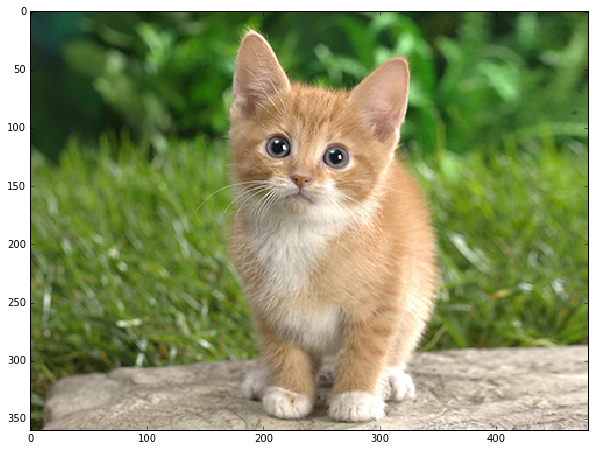

In [7]:
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

- Adorable, let's classify it!

In [8]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 281


- The net gives us a vector or probabilities; the most probable class was the 281st one. But is that correct? Let's check the ImageNet labels...

In [9]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !/opt/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]

output label: n02123045 tabby, tabby cat


- "Tabby cat" is correct! But let's also look at other top (but less confident predictions).

In [10]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.31243625, 'n02123045 tabby, tabby cat'),
 (0.23797157, 'n02123159 tiger cat'),
 (0.12387245, 'n02124075 Egyptian cat'),
 (0.10075716, 'n02119022 red fox, Vulpes vulpes'),
 (0.070957333, 'n02127052 lynx, catamount')]

- We see that less confident predictions are sensible.

## Switching to GPU Mode
- Let's see how long classification took, and compare it to GPU mode.

In [11]:
%timeit net.forward()

1 loop, best of 3: 7.69 s per loop


- That's a while, even for a batch of 50 images. Let's switch to GPU mode.

In [12]:
caffe.set_device(0)    # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
net.forward()          # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 33.9 ms per loop


- That should be must faster!

## Examining intermediate output
- A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

- For each layer, let's look at the activation shapes, which typically have the form (`batch_size`, `channel_dim`, `height`, `width`).
    
    The activations are exposed as an `OrderedDict, net.blobs`.

In [13]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


- Now look at the parameter shapes. The parameters are exposed as another `OrderedDict, net.params`. We need to index the resulting values with either [`0`] for weights or [`1`] for biases.

    The param shapes typically have the for (`output_channel`, `input_channel`, `filter_height`, `filter_width`) (for the weights and the 1-dimensional shape (`output_channels`,) (for biases).

In [14]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


- Since we are dealing wtih four-dimensional data here, we'll define a helper function for visualizing sets of rectanglar heatmaps.

In [15]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

- First we'll look at the first layer filters, `conv1`

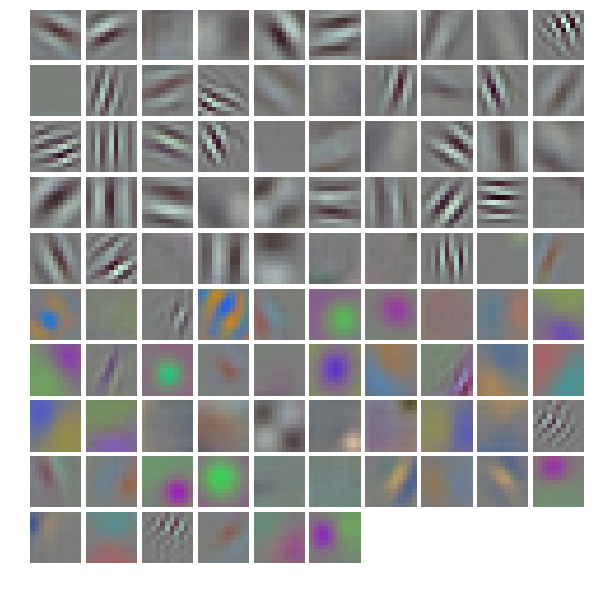

In [16]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

- The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

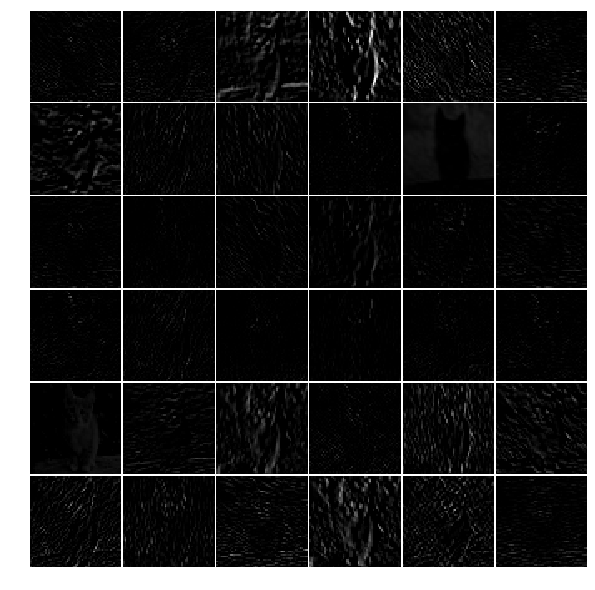

In [17]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat)

- The second layer filters, `conv2`

  There are 256 filters, each of which has dimension 5 x 5 x 48. We show only the first 48 filters, with each channel shown seperately, so that each filter is a row.

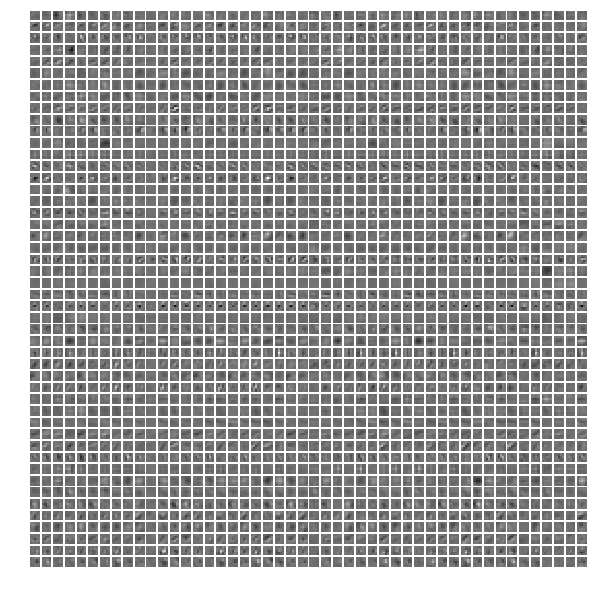

In [18]:
filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48 ** 2, 5, 5))

- The fifth layer after pooling, `pool5`

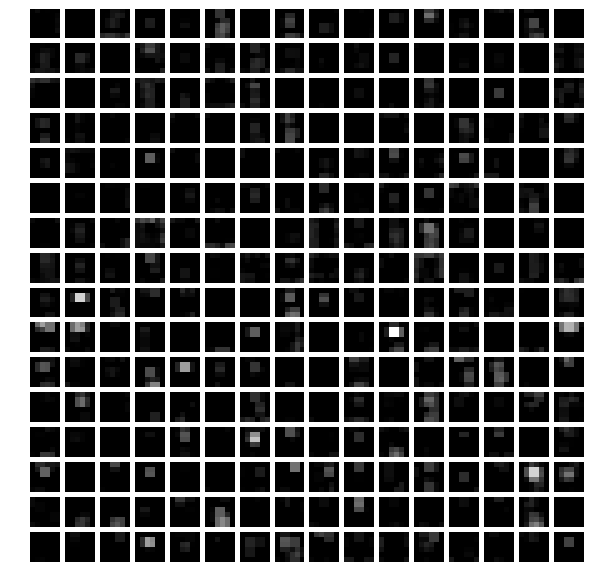

In [19]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)

- The first fully connected layer, `fc6` (rectified)

    We show the output values and the histogram of the positive values

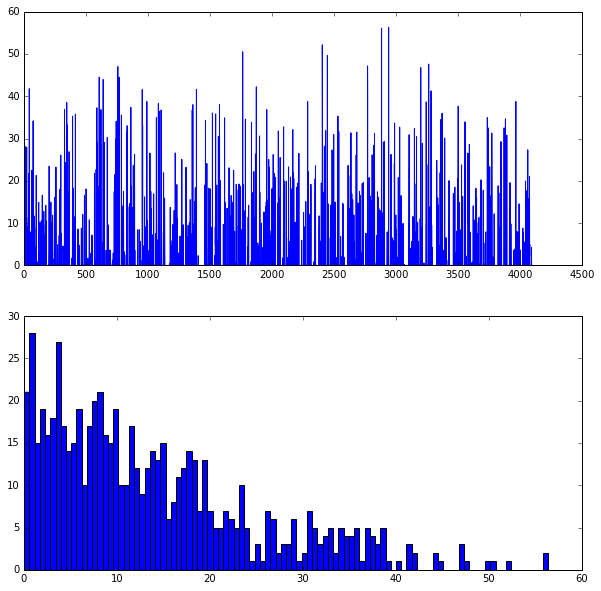

In [20]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

- The second fully connected layer, `fc7` (rectified)

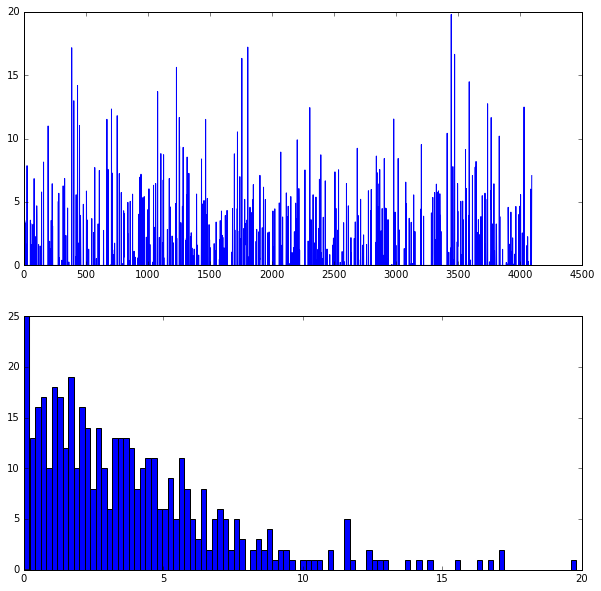

In [21]:
feat = net.blobs['fc7'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

- The final probability output, `prob`

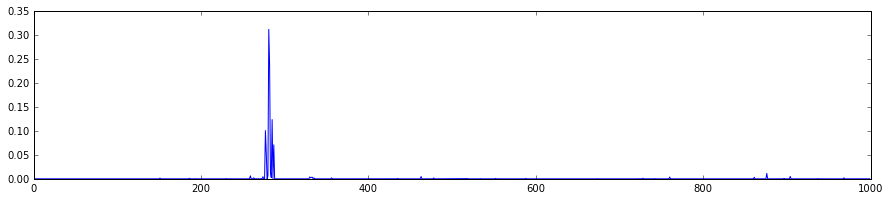

In [22]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15,3))
plt.plot(feat.flat)

Note the cluster of strong predictors; the labels are sorted semantically. The top peaks correspond to the top predicted labels, as shown above.

## Try your own image
Now we'll grab an image from the web and classify it using the steps above.

- The setting `my_image_url` to any JPEG image URL.

probabilities and labels:


[(0.33583248, 'n04285008 sports car, sport car'),
 (0.17165819, 'n04037443 racer, race car, racing car'),
 (0.14636357, 'n02974003 car wheel'),
 (0.10557656, 'n03459775 grille, radiator grille'),
 (0.10338662, 'n03100240 convertible')]

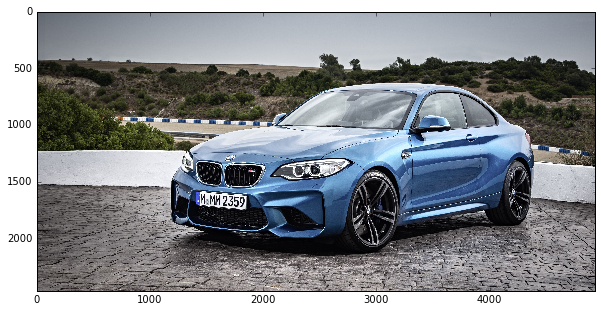

In [23]:
# download an image (if not already downloaded)
#my_image_url = "..." # paste your URL here
#!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('../Images/m3.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax ouptut
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])